# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

This notebook outlines the systematic assessment of errors in a BEL document. The data used is from the Alzheimer's Disease (AD) knowledge assembly model that has been annotated with the [NeuromMMSig Database](http://neurommsig.scai.fraunhofer.de/pathways/introduction). Error analysis is not meant to place blame on contributors to a BEL document, but rather to inform curation leaders where recuration efforts should be focused and to make analysts aware of the issues with a given BEL document.

### Notebook Setup

In [1]:
import logging
import os
import re
import time
from collections import Counter, defaultdict
from operator import itemgetter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fuzzywuzzy import process, fuzz
from matplotlib_venn import venn2


import pybel
from pybel.constants import PYBEL_DATA_DIR
from pybel.manager.cache import CacheManager
from pybel.parser import MetadataParser

import pybel_tools as pbt
from pybel_tools.utils import barh, barv

In [2]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
logging.getLogger('pybel.cache').setLevel(logging.CRITICAL)

### Notebook Provenance

The time of execution and the versions of the software packegs used are displayed explicitly.

In [4]:
time.asctime()

'Wed Apr  5 13:42:35 2017'

In [5]:
pybel.__version__

'0.4.5-dev'

In [6]:
pbt.__version__

'0.1.6-dev'

### Local Path Definitions

To make this notebook interoperable across many machines, locations to the repositories that contain the data used in this notebook are referenced from the environment, set in `~/.bashrc` to point to the place where the repositories have been cloned. Assuming the repositories have been `git clone`'d into the `~/dev` folder, the entries in `~/.bashrc` should look like:

```bash
...
export BMS_BASE=~/dev/bms
export BANANA_BASE=~/dev/banana
export PYBEL_RESOURCES_BASE=~/dev/pybel-resources
...
```

#### BMS 

The biological model store (BMS) is the internal Fraunhofer SCAI repository for keeping BEL models under version control. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/bms/

In [7]:
bms_base = os.environ['BMS_BASE']

#### PyBEL Resources

PyBEL resources is a set of namespaces and annotations that have been made avaliable by the [AETIONOMY](www.aetionomy.eu) project through collaboration between the PyBEL Core team and the [NeuromMMSig Database](http://neurommsig.scai.fraunhofer.de/pathways/introduction) developers. It can be downloaded from https://github.com/pybel/pybel-resources

In [8]:
pybel_resources_base = os.environ['PYBEL_RESOURCES_BASE']

## Data

The Alzheimer's Disease Knowledge Assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [9]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')

In [10]:
graph = pybel.from_pickle(pickle_path)

In [11]:
graph.version

'3.0'

## Error Analysis

As stated in the [pybel.BELGraph](http://pybel.readthedocs.io/en/latest/datamodel.html#pybel.BELGraph.warnings) documentation, all warnings during BEL compilation are stored in a list. These contain information about the BEL statement, the line number, the type of error, and the current annotations in the parser at the time of error. PyBEL tools makes many functions avaliable for systematically analyzing these errors.

The total number of errors is listed below.

In [12]:
len(graph.warnings)

4988

The types of errors in a graph and their frequencies can be calculated using [pbt.summary.count_error_types](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.count_error_types).

In [13]:
error_counter = pbt.summary.count_error_types(graph)

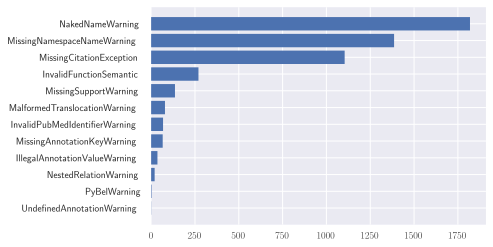

In [14]:
barh(error_counter, plt)

A common type of error is to use names that aren't contained within a namespace. These are thrown with [pybel.parser.parse_exceptions.MissingNamespaceNameWarning](http://pybel.readthedocs.io/en/latest/logging.html#pybel.parser.parse_exceptions.MissingNamespaceNameWarning). The PyBEL Tools function [pbt.summary.calculate_incorrect_name_dict]() creates a dictionary for each namespace which incorrect names were used and their frequencies.

In [15]:
incorrect_name_dict = pbt.summary.calculate_incorrect_name_dict(graph)

Using [pbt.utils.count_dict_values](), the number of unique incorrect names for each namespace is extracted and plotted.

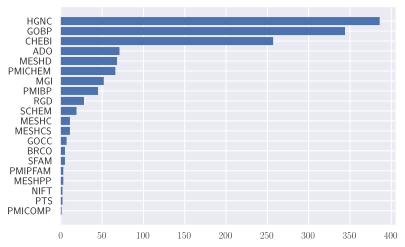

In [16]:
barh(pbt.utils.count_dict_values(incorrect_name_dict), plt)

Another common error is to write identifiers without a namespace, or for short, a naked name. The function  [pbt.summary.count_naked_names](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.count_naked_names) returns a counter of how many time each naked name appeared.

In [17]:
naked_names = pbt.summary.count_naked_names(graph)

The number of unique naked names can be directly calculated with `len()` on the resulting counter from [pbt.summary.count_naked_names](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.count_naked_names).

In [18]:
len(naked_names)

275

The 25 most common naked names are output below.

In [19]:
naked_names.most_common(25)

[('amyloid beta peptides', 309),
 ('27-hydroxycholesterol', 93),
 ('AICD', 73),
 ('2-butenal', 66),
 ('Midazolam', 66),
 ('aluminum chloride', 64),
 ('Ginkgo biloba extract 761', 46),
 ('Ceramides', 40),
 ('Tenivastatin', 40),
 ('Latrepirdine', 39),
 ('bis(4-hydroxycinnamoyl)methane', 38),
 ('icariin', 32),
 ('varenicline', 29),
 ('pozanicline', 27),
 ('Icariin', 26),
 ('APP,gmod(M)', 23),
 ('p', 16),
 ('PSEN1,gmod(M)', 16),
 ('Microglia', 15),
 ('huperzine A', 15),
 ('Rasagiline', 14),
 ('PtdIns(3,4,5)P3', 14),
 ('Diglycerides', 13),
 ('NICD', 12),
 ('YENPTY endocytosis motif (APP)', 12)]

## Error Analysis by Annotation

It might be useful to group the errors by a certain annotation/value pair. In these examples, the NeuroMMSig Database [subgraph](https://github.com/pybel/pybel-resources/blob/master/subgraph.belanno) annotations are used. Ultimately, the error frequency will be compared to the size of each subgraph.

First, the sizes of the top 30 largest subgraphs are shown below.

In [20]:
size_by_subgraph = pbt.summary.count_annotation_values(graph, 'Subgraph')

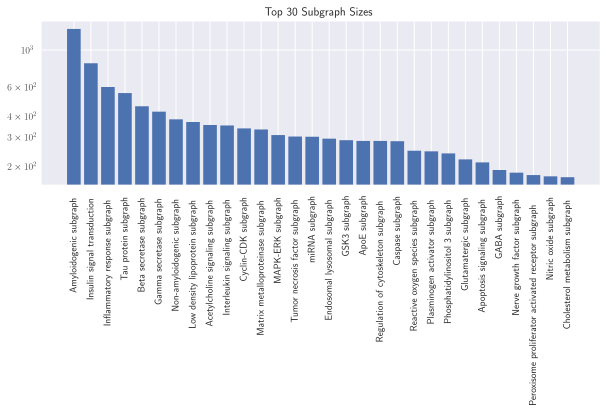

In [21]:
plt.figure(figsize=(10, 3))
barv(dict(size_by_subgraph.most_common(30)), plt)
plt.yscale('log')
plt.title('Top 30 Subgraph Sizes')
plt.show()

The list of all errors for each subgraph can be calculated with [pbt.summary.calculate_error_by_annotation](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.calculate_error_by_annotation).

In [22]:
error_by_subgraph = pbt.summary.calculate_error_by_annotation(graph, 'Subgraph')

These data are aggregated to a count of the number of items in each list with [pbt.utils.count_dict_values](http://pybel-tools.readthedocs.io/en/latest/utilities.html#pybel_tools.utils.count_dict_values). The top 30 most error-prone subgraphs are shown below.

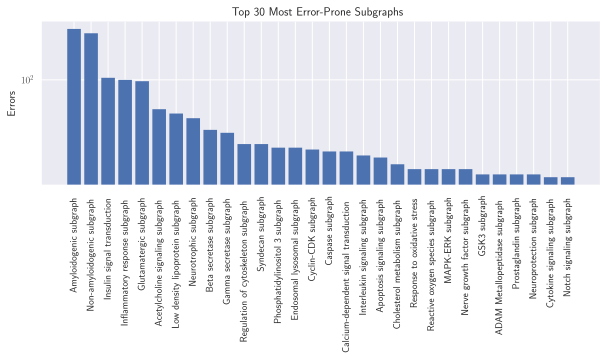

In [23]:
error_by_subgraph_count = pbt.utils.count_dict_values(error_by_subgraph)

plt.figure(figsize=(10, 3))
barv(dict(error_by_subgraph_count.most_common(30)), plt)
plt.yscale('log')
plt.ylabel('Errors')
plt.title('Top 30 Most Error-Prone Subgraphs')
plt.show()

Finally, the size to error ratio is calculated for each subgraph below. The 25 subgraphs with the highest error to size ratio are shown.

In [24]:
subgraphs = sorted(size_by_subgraph)
df_data = [(size_by_subgraph[k], error_by_subgraph_count[k], error_by_subgraph_count[k] / size_by_subgraph[k]) for k in subgraphs]

df = pd.DataFrame(df_data, index=subgraphs, columns=['Size', 'Errors', 'E/S Ratio'])

df.to_csv('~/Desktop/errors.tsv', sep='\t')
df.sort_values('E/S Ratio', ascending=False).head(25)

,Size,Errors,E/S Ratio
Syndecan subgraph,15,39,2.600000
Neurotrophic subgraph,62,57,0.919355
Metabolism of steroid hormones subgraph,7,6,0.857143
RhoA subgraph,4,3,0.750000
Amylin subgraph,20,14,0.700000
CRH subgraph,28,17,0.607143
Non-amyloidogenic subgraph,383,198,0.516971
Neuroprotection subgraph,49,25,0.510204
Protein biosynthesis subgraph,2,1,0.500000
Axonal transport subgraph,34,17,0.500000


The overall distribution of subgraph sizes and error counts is shown below. It indicates that they trend with a positive correlation, but there are clear outliers showing careful curation for large subgraphs, and sloppy curation for smaller ones.

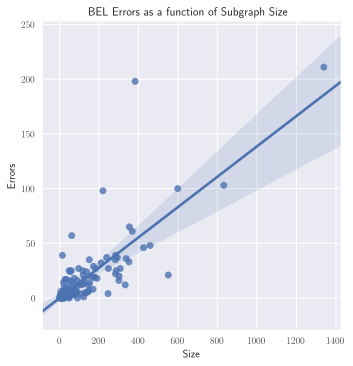

In [25]:
sns.lmplot('Size', 'Errors', data=df)
plt.title('BEL Errors as a function of Subgraph Size')
plt.show()

# Conclusions

The BEL language lacks utility for curator provenance. When multiple curators contribute to a single document, it's often difficult to trace where errors originate and identify the individual responsible for fixing them. When work is contracted, error analysis is also crucial for assessing the quality of the curation. PyBEL makes error messages programatically accessible and easy to summarize. 

These functions were used to build a web interface to give feedback to BEL curators who are not comfortable with programming. The code and instructions for deployment are avaliable at https://github.com/cthoyt/pybel-web-validator.